# CNN

In [8]:
import json
import os
import sys
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.layers import merge, Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.layers import Conv2D,Conv1D
from keras.layers.merge import dot, multiply, add, concatenate
from keras.layers import Merge
from keras.layers.core import Lambda,Reshape, Flatten, Dropout
from keras.layers.pooling import GlobalMaxPooling2D, GlobalMaxPooling1D,MaxPooling1D
from keras.models import Model
from keras.backend import transpose,batch_dot,expand_dims
from keras import optimizers
from HomeDepotCSVReader import HomeDepotReader
import Utilities
from DataPreprocessing import DataPreprocessing
from Feature_Word2Vec import Feature_Word2Vec
from AutomaticQueryExpansion import Word2VecQueryExpansion
import re
from nltk.corpus import stopwords
from keras.utils.np_utils import to_categorical
import pandas as pd
from FeatureEngineering import HomeDepotFeature
from keras.layers.wrappers import TimeDistributed
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [9]:
# train_filename = '../data/train_play.csv'
# test_filename = '../data/test_play.csv'
# soln_filename = '../data/solution.csv'
# attribute_filename = '../data/attributes_play.csv'
# description_filename = '../data/product_descriptions_play.csv'
# word2vec_model_path='model/word2vec_play.model'
# vocab_path='model/word2vec_play_vocab.json'
# embeddings_path='model/embeddings_play.npz'

train_filename = '../data/train.csv'
test_filename = '../data/test.csv'
soln_filename = '../data/solution.csv'
attribute_filename = '../data/attributes.csv'
description_filename = '../data/product_descriptions.csv'
word2vec_model_path='model/word2vec_cnn.model'
vocab_path='model/word2vec_cnn_vocab.json'
embeddings_path='model/embeddings_cnn.npz'

In [10]:
reader = HomeDepotReader()

train_query_df, product_df, attribute_df, test_query_df = reader.getQueryProductAttributeDataFrame(train_filename,
                                              test_filename,
                                              attribute_filename,
                                              description_filename)
print("train_query_df:",list(train_query_df))
print("product_df:", list(product_df))
print("attribute_df:", list(attribute_df))
print("test_query_df:", list(test_query_df))

===========Tranforming labels...
showing current values
trainDF: ['id', 'product_uid', 'search_term', 'relevance']
trainDF:    id  product_uid    search_term  relevance
0   2       100001  angle bracket        3.0
self.mergedLabelDF: ['relevance'] 
 <class 'pandas.core.frame.DataFrame'> (74067, 1)    relevance
0        3.0
Old unique Labels: [ 1.    1.25  1.33  1.5   1.67  1.75  2.    2.25  2.33  2.5   2.67  2.75
  3.  ]
newLabels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating new column for training:  relevance_int
===========Transform labels completed
train_query_df: ['id', 'product_uid', 'search_term', 'relevance', 'relevance_int', 'product_idx']
product_df: ['product_title', 'product_uid', 'product_description']
attribute_df: ['product_uid', 'name', 'value']
test_query_df: ['id', 'product_uid', 'search_term', 'product_idx']


In [11]:
#transform attribute into doc
dp = DataPreprocessing()
attribute_doc_df = dp.getAttributeDoc(attribute_df)
#attribute_doc_df
product_df=product_df.join(attribute_doc_df.set_index('product_uid'), on = 'product_uid')

In [12]:
### test data
soln_df = pd.read_csv(soln_filename, delimiter=',', low_memory=False, encoding="ISO-8859-1")
test_private_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Private')#,savepath='../data/test_private_gold.csv')
test_public_df = dp.getGoldTestSet(test_query_df, soln_df, testsetoption='Public')# savepath='../data/test_public_gold.csv')

In [13]:
#resample remove the low classes
resampled_train_query_df = train_query_df[train_query_df.relevance_int == 0]
min_samples=len(resampled_train_query_df)
for i in range(1,13):
    print(i)
    tmp_df = train_query_df[train_query_df.relevance_int == i]
    if len(tmp_df) > min_samples:
        # Shrink to balanced classes
        tmp_df = tmp_df.ix[np.random.choice(tmp_df.index,min_samples)]
        resampled_train_query_df=pd.concat([resampled_train_query_df,tmp_df])

    else:
        print("removing {} as too few values {}".format(i,len(tmp_df)))

1
removing 1 as too few values 4
2
3
removing 3 as too few values 5
4
5
removing 5 as too few values 9
6
7
removing 7 as too few values 11
8
9
removing 9 as too few values 19
10
11
removing 11 as too few values 11
12


# resample

In [14]:
#resample
ori_train_query_df=train_query_df
train_query_df=resampled_train_query_df

In [15]:
#resample classes too
mask=train_query_df['relevance_int'] == 2
train_query_df.loc[mask,'relevance_int']=1
mask=train_query_df['relevance_int'] == 4
train_query_df.loc[mask,'relevance_int']=2
mask=train_query_df['relevance_int'] == 6
train_query_df.loc[mask,'relevance_int']=3
mask=train_query_df['relevance_int'] == 8
train_query_df.loc[mask,'relevance_int']=4
mask=train_query_df['relevance_int'] == 10
train_query_df.loc[mask,'relevance_int']=5
mask=train_query_df['relevance_int'] == 12
train_query_df.loc[mask,'relevance_int']=6

In [16]:
#resample
train_query_df['relevance_int'].value_counts()

6    2105
5    2105
4    2105
3    2105
2    2105
1    2105
0    2105
Name: relevance_int, dtype: int64

# end resample

In [17]:

train_query_df = HomeDepotFeature().getFeature(train_query_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")
#,stopwords,stemming
#"spelling,nonascii" no diff.

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.0 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14735 entries, 17 to 35628
Data columns (total 6 columns):
id               14735 non-null int64
product_uid      14735 non-null int64
search_term      14735 non-null object
relevance        14735 non-null float64
relevance_int    14735 non-null int64
product_idx      14735 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 805.8+ KB
train_query_df final column:
 None


In [18]:
test_private_df = HomeDepotFeature().getFeature(test_private_df, product_df, attribute_df, test_private_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.01 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78419 entries, 2 to 147405
Data columns (total 5 columns):
id             78419 non-null int64
product_uid    78419 non-null int64
search_term    78419 non-null object
product_idx    78419 non-null object
relevance      78419 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.6+ MB
train_query_df final column:
 None


In [19]:
test_public_df = HomeDepotFeature().getFeature(test_public_df, product_df, attribute_df, test_public_df,
                        features="spelling,nonascii")

Performing spell correction
Performing non-ascii removal
Non-ascii clean on search_term took: 0.0 minutes
Non-ascii clean on product_title took: 0.03 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33648 entries, 1 to 147404
Data columns (total 5 columns):
id             33648 non-null int64
product_uid    33648 non-null int64
search_term    33648 non-null object
product_idx    33648 non-null object
relevance      33648 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.5+ MB
train_query_df final column:
 None


In [20]:
# product_df['content'] = train_query_df['search_term'].map(str) + " " + \
#                         product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) + " " + \
#                         product_df['attr_json'].map(str)

# product_df['content'] = product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) 

product_df['content'] = product_df['product_title'].map(str) + " . " + \
                        product_df['product_description'].map(str) 

# product_df['content'] = product_df['product_title'].map(str) + "." + \
#                         product_df['product_description'].map(str)  + "." + \
#                         product_df['attr_json'].map(str) 

# ## no attribute
# product_df['content'] = product_df['product_title'].map(str) + " " + \
#                         product_df['product_description'].map(str) 
        
#product_df['content']

In [21]:
len(test_public_df)

33648

# start noun

In [22]:
import spacy
import en_vectors_glove_md
nlp = spacy.load('en')
#nlp = en_vectors_glove_md.load()
nlp.vocab.length

742225

In [23]:
i=0
query_list_all=[]
query_list_flattened_all=[]
for query_row in train_query_df.itertuples():        
    query=nlp(str(query_row.search_term))
    query_list=[noun_phrase.text for noun_phrase in query.noun_chunks ]
#     print(query_list)
#     print(' '.join(query_list))
    query_list_all+=[query_list]
    query_list_flattened_all+=[' '.join(query_list)]
#     i+=1
#     print(i)
#     if i >= 20:
#         break            

In [24]:
np.array(query_list_flattened_all).shape

(14735,)

In [25]:
train_query_df['nouns_only_query']=pd.Series(np.array(query_list_all),index=train_query_df.index)
train_query_df['nouns_only_flat_query']=pd.Series(query_list_flattened_all,index=train_query_df.index)

In [26]:
train_query_df

,id,product_uid,search_term,relevance,relevance_int,product_idx,nouns_only_query,nouns_only_flat_query
17,69,100017,door guards,1.0,0,"Int64Index([11], dtype='int64')",[door guards],door guards
49,178,100033,kitchen cabinet finishes,1.0,0,"Int64Index([21], dtype='int64')",[kitchen cabinet],kitchen cabinet
56,195,100034,mortar tools,1.0,0,"Int64Index([22], dtype='int64')",[mortar tools],mortar tools
217,696,100119,paint roller inserts,1.0,0,"Int64Index([87], dtype='int64')",[paint roller],paint roller
226,734,100128,garage chair organizer,1.0,0,"Int64Index([93], dtype='int64')",[garage chair organizer],garage chair organizer
230,742,100129,face masks,1.0,0,"Int64Index([94], dtype='int64')",[face],face
242,764,100134,plastic covers,1.0,0,"Int64Index([99], dtype='int64')",[plastic],plastic
270,867,100149,funnel 6 inch,1.0,0,"Int64Index([109], dtype='int64')",[6 inch],6 inch
289,912,100152,roof leaf broom,1.0,0,"Int64Index([112], dtype='int64')",[roof leaf broom],roof leaf broom
290,918,100152,lawn tractor,1.0,0,"Int64Index([112], dtype='int64')",[lawn tractor],lawn tractor


In [27]:
i=0
doc_list_all=[]
doc_list_flattened_all=[]
for doc_row in product_df.itertuples():        
    doc=nlp(str(doc_row.content))
    doc_list=[noun_phrase.text for noun_phrase in doc.noun_chunks ]
#     print(query_list)
#     print(' '.join(query_list))
    doc_list_all+=[doc_list]
    doc_list_flattened_all+=[' '.join(doc_list)]
#     i+=1
#     print(i)
#     if i >= 20:
#         break    


In [28]:
product_df['nouns_only_content']=pd.Series(np.array(doc_list_all),index=product_df.index)
product_df['nouns_only_flat_content']=pd.Series(doc_list_flattened_all,index=product_df.index)

In [29]:
product_df

,product_title,product_uid,product_description,attr_json,content,nouns_only_content,nouns_only_flat_content
0,simpson strong tie 12 gauge angle,100001,not only do angles make joints stronger they a...,'bullet01' 'versatile connector for various 90...,simpson strong tie 12 gauge angle . not only d...,"[simpson strong tie 12 gauge angle, angles, jo...",simpson strong tie 12 gauge angle angles joint...
1,behr premium textured deck over 1 gal sc 141 t...,100002,behr premium textured deck over is an innovati...,'application method' 'brush roller spray' 'ass...,behr premium textured deck over 1 gal sc 141 t...,"[behr premium textured deck, 1 gal sc 141 tugb...",behr premium textured deck 1 gal sc 141 tugboa...
2,delta verso 1 handle shower only faucet trim k...,100005,update your bathroom with the delta verso sing...,'bath faucet type' 'combo tub and shower' 'bui...,delta verso 1 handle shower only faucet trim k...,"[verso, delta verso 1 handle, shower, kit, chr...",verso delta verso 1 handle shower kit chrome v...
3,whirlpool 1 9 cu. ft. over the range convectio...,100006,achieving delicious results is almost effortle...,'appliance type' 'over the range microwave' 'a...,whirlpool 1 9 cu. ft. over the range convectio...,"[whirlpool 1 9 cu. ft, the range convection mi...",whirlpool 1 9 cu. ft the range convection micr...
4,lithograph lighting quantum 2 light black led ...,100007,the quantum adjustable 2 light led black emerg...,'battery power type' 'ni cad' 'battery size' '...,lithograph lighting quantum 2 light black led ...,"[light black, emergency fixture unit, the quan...",light black emergency fixture unit the quantum...
5,house of fara 3 4 in. x 3 in. x 8 ft. mdf flut...,100009,get the house of fara 3 4 in. x 3 in. x 8 ft. ...,'application' 'door window' 'bullet01' 'made o...,house of fara 3 4 in. x 3 in. x 8 ft. mdf flut...,"[house, fara, x 8 ft, mdf fluted casing, the h...",house fara x 8 ft mdf fluted casing the house ...
6,valley view industries metal stakes 4 pack,100010,valley view industries metal stakes 4 pack are...,'attachable' 'no' 'bullet01' 'can be used with...,valley view industries metal stakes 4 pack . v...,"[valley view industries, valley, view industri...",valley view industries valley view industries ...
7,toro personal pace re cycler 22 in. variable s...,100011,re cycler 22 in. personal pace variable speed ...,'assembled depth in. ' '59 in' 'assembled heig...,toro personal pace re cycler 22 in. variable s...,"[personal pace, cycler, speed self, gas lawn m...",personal pace cycler speed self gas lawn mower...
8,hampton bay caramel simple weave bamboo roll u...,100012,the 96 in. wide caramel simple weave roll up b...,'actual blind shade width in. ' '96' 'arched' ...,hampton bay caramel simple weave bamboo roll u...,"[hampton bay, bamboo roll, shade, bamboo shade...",hampton bay bamboo roll shade bamboo shade a u...
9,insinuator sink top switch single outlet for i...,100013,the insinuator sink top switch single outlet f...,'bullet01' 'kit includes satin nickel chrome a...,insinuator sink top switch single outlet for i...,"[insinuator, single outlet, insinuator dispose...",insinuator single outlet insinuator disposers ...


# end noun

In [30]:
#https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors
def doc_to_wordlist( doc, vocab=['<PAD>', '<OOV>'], remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    #review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    if remove_non_letters:
        doc = re.sub("[^a-zA-Z]"," ", doc)
    # 2a. remove non-letters, numbers
    if remove_non_letters_numbers:
        doc = re.sub("[^a-zA-Z0-9]"," ", doc)
    #
    # 3. Convert words to lower case and split them
    words = doc.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        #words = [w for w in words if not w in stops]
        new_words = []
        for w in words:
            if not w in stops:
                new_words.append(w)
                #if w not in vocab: #TODO: temp removal, too slow
                #    vocab.append(w)
    
    # 5. Return a list of words
    return new_words,vocab

# words,vocab=doc_to_wordlist(product_df['content'][0],remove_stopwords=True, remove_non_letters=False, remove_non_letters_numbers=True)
# print(len(words),len(vocab))
# print(vocab)
# words,vocab=doc_to_wordlist(product_df['content'][0],remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True)
# print(len(words),len(vocab))
# print(vocab)
# product_df['content'][0]

In [31]:
# # Download the punkt tokenizer for sentence splitting
import nltk.data
# nltk.download()   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [32]:
### tokenisation
class alt_tokenizer():
    def tokenize(self,sentence):
        token = re.compile("[\w]+(?=n't)|n't|\'s|\'m|\'ll|[\w]+|[.?!;,\-\(\)—\:'\"]")
        return token.findall(sentence)

#load alt tokenizer
my_alt_tokenizer = alt_tokenizer()

In [33]:
# Define a function to split a doc into parsed sentences
def doc_to_sentences( doc, tokenizer, vocab=None, remove_stopwords=False, remove_non_letters=False, remove_non_letters_numbers=True ):
    if vocab is None:
        vocab = ['<PAD>', '<OOV>']
    
    # Function to split a doc into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(doc.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            (words,vocab) = doc_to_wordlist( raw_sentence, vocab, remove_stopwords )
            sentences.append(words)
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences,vocab


In [34]:
print(product_df['product_description'][10])
print(product_df['content'][10])
vocab=['<PAD>', '<OOV>']
#retokenise:
tokens=my_alt_tokenizer.tokenize(product_df['content'][10])
print(tokens)
words,vocab=doc_to_wordlist(str(tokens),remove_stopwords=True, \
                            remove_non_letters=False, remove_non_letters_numbers=True)
print(len(words))
#print(len(doc_to_wordlist(product_df['content'][0],remove_stopwords=False)))
print(len(vocab))
print(vocab)

make grilling great with this handsome and functional grill gazebo this grill gazebo is a great gift to anyone who loves to grill yourself included providing shade and protection from harmful uv rays rain and debris this grill gazebo will help keep your grill looking great and keep you cool when grilling in the hot summer sun this grill gazebo comes with a rich brown canopy and black frame its 8 foot width means that you can easily fit most size grills beneath and standing at 8 feet tall even the tallest grill afficionado will fit beneath comfortably upgrade your grilling today with the addition of this stunning grill gazebo vented canopy built in lattice work is great for holding grill accessories2 built in tile shelves versatile design will coordinate easily durable powder coated finish low maintenance easy to clean
sun joy calais 8 ft. x 5 ft. x 8 ft. steel tile fabric grill gazebo . make grilling great with this handsome and functional grill gazebo this grill gazebo is a great gift

In [35]:
product_df['content'][100]
vocab=None
sentences,vocab = doc_to_sentences(product_df['content'][100],tokenizer,remove_stopwords=True, \
                            remove_non_letters=False, remove_non_letters_numbers=True)
print(len(sentences))
print(len(vocab))
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=True)))
# print(len(doc_to_sentences(product_df['content'][0],tokenizer,remove_stopwords=False)))
# product_df['content'][0]

2
2


In [36]:
sentences = []  # Initialize an empty list of sentences
query_sentences = []
doc_sentences = []
vocab=['<PAD>', '<OOV>']
print("Parsing sentences from search string")
for query in train_query_df['nouns_only_flat_query']:#["search_term"]:
    words,vocab=doc_to_wordlist(query,vocab, remove_stopwords=True, remove_non_letters=False, remove_non_letters_numbers=True)
    query_sentences += [words]
 

Parsing sentences from search string


In [37]:
print(len(query_sentences))
print(len(vocab))

14735
2


In [38]:
print("Parsing sentences from unlabeled set")
for doc in product_df['nouns_only_flat_content']:#['content']:
    words,vocab=doc_to_wordlist(doc,vocab, remove_stopwords=True,remove_non_letters=False, remove_non_letters_numbers=True)
    doc_sentences += [words]

sentences = query_sentences+doc_sentences   

Parsing sentences from unlabeled set


In [39]:
print(len(sentences))
print(len(vocab))

139163
2


In [40]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300#50#300    # Word vector dimensionality                      
min_word_count = 1#5#40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 0 #1e-3   # Downsample setting for frequent words
iterations = 10

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print("Training model...")
word2vec_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, iter=iterations)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
word2vec_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
#model_name = "300features_40minwords_10context"
word2vec_model.save(word2vec_model_path)

2017-04-08 00:32:20,774 : INFO : collecting all words and their counts
2017-04-08 00:32:20,780 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-04-08 00:32:20,790 : INFO : PROGRESS: at sentence #10000, processed 24910 words, keeping 3527 word types
2017-04-08 00:32:20,881 : INFO : PROGRESS: at sentence #20000, processed 455537 words, keeping 18408 word types


Training model...


2017-04-08 00:32:21,042 : INFO : PROGRESS: at sentence #30000, processed 1220942 words, keeping 29762 word types
2017-04-08 00:32:21,211 : INFO : PROGRESS: at sentence #40000, processed 1978492 words, keeping 37563 word types
2017-04-08 00:32:21,377 : INFO : PROGRESS: at sentence #50000, processed 2723088 words, keeping 43951 word types
2017-04-08 00:32:21,538 : INFO : PROGRESS: at sentence #60000, processed 3477981 words, keeping 49749 word types
2017-04-08 00:32:21,695 : INFO : PROGRESS: at sentence #70000, processed 4225973 words, keeping 54420 word types
2017-04-08 00:32:21,847 : INFO : PROGRESS: at sentence #80000, processed 4951597 words, keeping 59408 word types
2017-04-08 00:32:22,000 : INFO : PROGRESS: at sentence #90000, processed 5682164 words, keeping 63603 word types
2017-04-08 00:32:22,154 : INFO : PROGRESS: at sentence #100000, processed 6409247 words, keeping 67642 word types
2017-04-08 00:32:22,310 : INFO : PROGRESS: at sentence #110000, processed 7152129 words, keepin

In [41]:
print(len(word2vec_model.wv.vocab))
#word2vec_model.wv.vocab

80839


In [42]:
print(word2vec_model.most_similar('wood', [], 3))
#print(word2vec_model.most_similar('temperature'))

[('hardwood', 0.4600945711135864), ('hardwoods', 0.435436487197876), ('wooden', 0.42368432879447937)]


In [43]:
print(word2vec_model.most_similar('whirlpool', [], 3))

[('caprios', 0.5430225133895874), ('lawson', 0.48251500725746155), ('frigidaire', 0.45595991611480713)]


In [44]:
print(word2vec_model.most_similar('kitchen', [], 3))

[('chef', 0.37319156527519226), ('streamlined', 0.339102178812027), ('contemporary', 0.33882251381874084)]


In [45]:
print(word2vec_model.most_similar('shower', [], 3))

[('showering', 0.49827834963798523), ('infinity', 0.4335968792438507), ('diverter', 0.4249054491519928)]


In [60]:
print(word2vec_model.most_similar('stool', [], 3))

[('stools', 0.6497994661331177), ('pub', 0.5201863050460815), ('barstool', 0.5085264444351196)]


In [59]:
print(word2vec_model.most_similar('microwave', [], 3))

[('spotlight', 0.4331069886684418), ('lights', 0.40009617805480957), ('hid', 0.39662158489227295)]


In [58]:
train_query_df[train_query_df['product_uid'] == 100020]
test_public_df[test_public_df['product_uid'] == 100020]
test_private_df[test_private_df['product_uid'] == 100020]

,id,product_uid,search_term,product_idx,relevance
81,109,100020,bazz lighting,"Int64Index([54673], dtype='int64')",2.67
82,110,100020,led light strip,"Int64Index([54673], dtype='int64')",2.67


In [126]:
# #w2v=Feature_Word2Vec(modelFilename=word2vec_model_path)#modelFilename=word2vec_model_path
# w2v=Feature_Word2Vec()
# #sentences=w2v.convertDFIntoSentences(product_df,'content')
# #print(sentences)
# w2v.trainModel(sentences)

In [127]:
# len(w2v.model.wv.vocab)

In [128]:
# w2vExpand=Word2VecQueryExpansion(modelFilename=word2vec_model_path)
# query="cooking"
# print("Expanding query: ")
# print(w2vExpand.getExpandedQuery(query,maxNoOfAdditionalWords=2,minSimilarityLevel=0.65,))

In [129]:
# print(w2v.getVectorFromWord('wood'))
# print(w2v.getSimilarWordVectors('wood',5))
# print(len(w2v.getVectorFromWord('wood')))

# embeddings to keras
http://ben.bolte.cc/resources/embeddings/embeddings.html

In [130]:
#vocab = dict([(k, v.index) for k, v in w2v.model.wv.vocab.items()])
#vocab = dict([(k, v.index) for k, v in word2vec_model.wv.vocab.items()])
word2vec_vocab = dict([(k, v.index+2) for k, v in word2vec_model.wv.vocab.items()]) # Leave room for <pad>
word2vec_vocab['<PAD>']=0
word2vec_vocab['<OOV>']=1
with open(vocab_path, 'w') as f:
    f.write(json.dumps(word2vec_vocab))

In [131]:
#weights = w2v.model.wv.syn0
weights = word2vec_model.wv.syn0
np.save(open(embeddings_path, 'wb'), weights)

In [132]:
def load_vocab(vocab_path):
    """
    Load word -> index and index -> word mappings
    :param vocab_path: where the word-index map is saved
    :return: word2idx, idx2word
    """

    with open(vocab_path, 'r') as f:
        data = json.loads(f.read())
    word2idx = data
    idx2word = dict([(v, k) for k, v in data.items()])
    return word2idx, idx2word

In [133]:
word2idx, idx2word = load_vocab(vocab_path)

In [134]:
def word2vec_embedding_layer(embeddings_path,masking=True,trainable=False):
    """
    Generate an embedding layer word2vec embeddings
    :param embeddings_path: where the embeddings are saved (as a numpy file)
    :return: the generated embedding layer
    """

    saved_weights = np.load(open(embeddings_path, 'rb'))
    padding_weight = np.zeros(num_features)
    padding_weight=np.expand_dims(padding_weight,axis=0)
    oov_weight = np.random.rand(num_features)
    oov_weight=np.expand_dims(oov_weight,axis=0)    
    weights=np.concatenate((padding_weight,saved_weights), axis=0)
    layer = Embedding(input_dim=weights.shape[0], output_dim=weights.shape[1], weights=[weights],mask_zero=masking, trainable=trainable)
    return layer

In [135]:
#a = np.load(open(embeddings_path, 'rb'))
# b = np.zeros(50)
# b=np.expand_dims(b,axis=0)
# b.shape

In [136]:
# c=np.concatenate((b,a), axis=0)
# c[0:2]

In [137]:
# idx2word = []
# idx2word=[dict([(v, k) for k, v in word2idx.items()])]
# idx2word.insert(0, '<PAD>')

In [138]:
idx2word[0]

'<PAD>'

In [139]:
idx2word[1]

'<OOV>'

In [140]:
idx2word[2]

'door'

In [141]:
print_tokens=False

In [142]:
# variable arguments are passed to gensim's word2vec model
# if options.train:
#     print('Training Word2Vec...')
#     create_embeddings(options.data, options.embeddings, options.vocab, size=100, min_count=5, window=5, sg=1, iter=25)

word2idx, idx2word = load_vocab(vocab_path)

if print_tokens:
    print('Tokens:', ', '.join(word2idx.keys()))



# convert to idx

In [143]:
len(word2idx.keys())

80776

In [144]:
#todo need to pass in word2idx
def convert_word2idx(word,verbose=False):
    if verbose:
        print("word: {}".format(word))
    if str(word) not in word2idx.keys():
        return 1
    else:
        return word2idx[word]

In [145]:
#convert_word2idx('bracket')
for word in doc_sentences[100]:
    idx=convert_word2idx(word)
    #print(idx)

In [146]:
def query_sent2idx(sentences):
    query_word2vec_idx_list=[]
    queries=sentences #w2v.convertDFIntoSentences(df,col)
    print(len(queries))
    for query in queries:
        idx_list = []
        for word in query:
#             if word not in word2idx.keys():
#                 idx_list+=[0]#[len(word2idx.keys())] # use last as special key #TODO: well we need to fix this. Using 0 for now so it's in range To OOV or something random
#             else:
#                 idx_list+=[word2idx[word]]
            idx_list+=[convert_word2idx(word)]
        query_word2vec_idx_list+=[idx_list]
        #print("=====")
        #print(idx_list)
        #print("=====")
    return query_word2vec_idx_list


In [147]:
#query_word2vec_idx_list = query_sent2idx(train_query_df['search_term'])
query_word2vec_idx_list = query_sent2idx(query_sentences)
#print(query_word2vec_idx_list)

14735


In [148]:
# def doc_sent2idx(df,col):
#     doc_word2vec_idx_list=[]
#     for row in df.iteritems():
#         a=w2v.convertDFIntoSentences(row,col)
#         print(a)
# #    print(len(queries))
# #     for query in queries:
# #         idx_list = []
# #         for word in query:
# #             if word not in word2idx.keys():
# #                 idx_list+=[len(word2idx.keys())] # use last as special key
# #             else:
# #                 idx_list+=[word2idx[word]]
# #         query_word2vec_idx_list+=[idx_list]
# #         print("=====")
# #         print(idx_list)
# #         print("=====")
#     return doc_word2vec_idx_list

In [149]:
#TODO: this is fucked. just bodge for testing nn
#doc_word2vec_idx_list = query_sent2idx(product_df,'product_title')
joined_df=train_query_df.join(product_df.set_index('product_uid'), on='product_uid')

joined_doc_sentences=[]
for doc in joined_df['content']:
    words,vocab = doc_to_wordlist(doc,vocab, remove_stopwords=True)
    joined_doc_sentences+=[words]
    
doc_word2vec_idx_list = query_sent2idx(joined_doc_sentences)
#print(doc_word2vec_idx_list)

14735


In [150]:
len(joined_doc_sentences)

14735

In [151]:
doc_word2vec_idx_list[0:10]
#query_word2vec_idx_list[100:110]
#query_sent2idx(joined_doc_sentences[0])

[[2765,
  334,
  79,
  1567,
  29,
  1567,
  17894,
  55,
  654,
  604,
  2765,
  334,
  79,
  1567,
  29,
  1567,
  29,
  17,
  299,
  55,
  17894,
  85,
  654,
  778,
  11,
  551,
  385,
  195,
  66,
  5312,
  4586,
  124,
  4,
  872,
  394,
  14,
  502,
  1534,
  241,
  516,
  17894,
  5,
  3,
  872,
  2,
  162,
  2624,
  4990,
  516,
  774,
  60,
  4360,
  90,
  2175,
  551,
  489,
  18,
  14,
  502,
  1534,
  195,
  47931,
  29,
  1567,
  29,
  17,
  299,
  778,
  55,
  11,
  516,
  17894,
  5],
 [2085,
  1455,
  758,
  29,
  2592,
  279,
  29,
  343,
  143,
  140,
  105,
  11,
  97,
  1383,
  192,
  14,
  12517,
  143,
  140,
  105,
  11,
  97,
  1383,
  192,
  2085,
  3605,
  50,
  69,
  60,
  583,
  5167,
  97,
  579,
  118,
  3,
  91,
  1893,
  1383,
  192,
  2339,
  1733,
  7,
  1414,
  441,
  30,
  105,
  11,
  185,
  1894,
  1589,
  95,
  192,
  2715,
  6592,
  87,
  185,
  7394,
  1197,
  219,
  4505,
  6770,
  241,
  965,
  192,
  201,
  157,
  7534,
  219,
  861,
  3,
  

In [152]:
# # cosine similarity model
# print('Building model...')
# input_a = Input(shape=(1,), dtype='int32', name='input_a')
# input_b = Input(shape=(1,), dtype='int32', name='input_b')
# embeddings = word2vec_embedding_layer(embeddings_path)
# embedding_a = embeddings(input_a)
# embedding_b = embeddings(input_b)
# similarity = merge([embedding_a, embedding_b], mode='cos', dot_axes=2)
# model = Model(input=[input_a, input_b], output=similarity)
# model.compile(optimizer='sgd', loss='mse') # optimizer and loss don't matter


# word_a = 'wood'#raw_input('First word: ')
# if word_a not in word2idx:
#     print('"%s" is not in the index' % word_a)
# word_b = 'fan'#raw_input('Second word: ')
# if word_b not in word2idx:
#     print('"%s" is not in the index' % word_b)
# output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
# print('%f' % output)

# GLOVE

In [153]:
word2vec_vocab['wood']

12

In [154]:
import csv
### GLOVE
vocab_size=len(word2vec_vocab)#word2vec_model.wv.vocab)
input_size=num_features
LOAD_GLOVE=False
pretrainedEmbedding='../data/glove.6B.100d.txt'
### Load GloVe Pre-Trained Embedding ###

if LOAD_GLOVE:
    # Read in the pre-trained embeddings. Delimiter by space, without any quote
    pretrain_embeddings = pd.read_csv(pretrainedEmbedding, header=None, delimiter=' ', quoting=csv.QUOTE_NONE)

    # Convert data frame into a dict
    pretrain_embeddings = pretrain_embeddings.set_index(0).T.to_dict('list')

    pretrain_embeddings_sorted = np.random.rand(vocab_size, input_size)

    count = 0
    for word,index in word2vec_vocab.items():
        if word in pretrain_embeddings:
            count+=1
            pretrain_embeddings_sorted[index] = pretrain_embeddings[word]

    print("Number of pre-trained word/embedding matched: ", count, " out of ", vocab_size)

# Define model

In [155]:
lengths=[]
for i in doc_word2vec_idx_list:
    lengths+=[len(i)]

(array([  5.20000000e+01,   4.77000000e+02,   1.32300000e+03,
          1.89700000e+03,   1.76700000e+03,   1.52200000e+03,
          1.42400000e+03,   1.20400000e+03,   9.78000000e+02,
          7.56000000e+02,   6.40000000e+02,   5.41000000e+02,
          4.55000000e+02,   3.90000000e+02,   2.61000000e+02,
          1.94000000e+02,   1.95000000e+02,   1.57000000e+02,
          1.00000000e+02,   7.60000000e+01,   6.60000000e+01,
          4.00000000e+01,   5.30000000e+01,   3.40000000e+01,
          2.60000000e+01,   2.10000000e+01,   1.50000000e+01,
          1.10000000e+01,   1.40000000e+01,   7.00000000e+00,
          7.00000000e+00,   9.00000000e+00,   2.00000000e+00,
          6.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

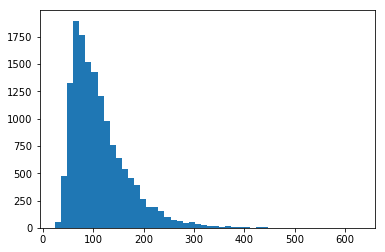

In [156]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lengths,bins=50)

In [209]:
query_min_len = len(min(query_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
doc_min_len = len(min(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
query_max_len = 6 #covers 95.74% of the search lengths (see data exploration)
# find longest sub list
doc_max_len = 200 #len(max(doc_word2vec_idx_list,key=len)) #400 # todo: confirm this is sensible
query_filter_size_m=2
doc_filter_size_m=2
num_filters=100 #aka featuremaps

# Model Hyperparameters
embedding_dim = num_features#100 #50
#filter_sizes = (3, 8)
#num_filters = 10
dropout_prob = 0.2 #0.5 from paper #(0.5, 0.8)
hidden_dims = 50
#https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py

print(doc_max_len)
print(query_max_len)
print(doc_min_len)
print(query_min_len)

200
6
24
0


In [210]:
#TODO testing
#doc_max_len=doc_min_len
print('Building model...')

embeddings = word2vec_embedding_layer(embeddings_path,masking=False,trainable=True)

## embedding lookup
input_query = Input(shape=(query_max_len+(query_filter_size_m-1)*2,), dtype='int32', name='input_query')
input_doc = Input(shape=(doc_max_len+(doc_filter_size_m-1)*2,), dtype='int32', name='input_doc')
input_exact_match = Input(shape=(query_max_len,doc_max_len), dtype='float32', name='input_exact_match')
embedding_query = embeddings(input_query)  # (None, 6, 100)
embedding_doc = embeddings(input_doc)      # (None, 400, 100)
#TODO: do we want drop out here? 

## convolution layer
# include bias vector to result of each feature map
# relu activation
conv_query_output = Conv1D(filters=num_filters,
            kernel_size=query_filter_size_m,
            strides=1, 
            padding='same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
            dilation_rate=1, 
            activation='relu', 
            use_bias=True, 
            kernel_initializer='glorot_uniform', 
            bias_initializer='glorot_uniform',#'zeros', 
            kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, bias_constraint=None)(embedding_query)

conv_doc_output = Conv1D(filters=num_filters,
            kernel_size=doc_filter_size_m,
            strides=1, 
            padding='same', # 'valid', #The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's
            dilation_rate=1, 
            activation='relu', 
            use_bias=True, 
            kernel_initializer='glorot_uniform', 
            bias_initializer='glorot_uniform',#'zeros', 
            kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
            kernel_constraint=None, bias_constraint=None)(embedding_doc)
#TODO: do we want drop out here?

## Pooling layer
# TODO: sliding Max Pooling instead of original Global Pooling?
conv_query_output=GlobalMaxPooling1D()(conv_query_output)
conv_doc_output=GlobalMaxPooling1D()(conv_doc_output)

## similarity matrix
#cos_distance = merge([conv_query_output, conv_doc_output], mode='cos', dot_axes=1) # magic dot_axes works here!
#cos_distance = Reshape((1,))(cos_distance)
#cos_similarity = Lambda(lambda x: 1-x)(cos_distance)
#similarity_output=dot([conv_query_output, conv_doc_output], axes=1, normalize=True)
similarity_output = Dense(num_filters,activation='linear',use_bias=False, \
                          kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, \
                          bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, \
                          bias_constraint=None)(conv_doc_output)
#TODO: is bias needed?
similarity_output = dot([conv_query_output, similarity_output], axes=1, normalize=True)

## Concatenate (join layer)
concat_output = concatenate([conv_query_output,conv_doc_output,similarity_output])

## Hidden layer
hidden_output = Dense(embedding_dim*2+1,activation='relu',use_bias=True, \
                          kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', \
                          kernel_regularizer=None, \
                          bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, \
                          bias_constraint=None)(concat_output)

## dropout at softmax layer
dropout_output = Dropout(dropout_prob)(hidden_output) #noise_shape=None, seed=None)

## Final layer
output = Dense(1,activation='sigmoid', kernel_initializer='glorot_uniform')(dropout_output)
#categorical
#output = Dense(7, activation='softmax', kernel_initializer='glorot_uniform')(dropout_output)
#output = Dense(13, activation='softmax', kernel_initializer='glorot_uniform')(dropout_output)

# build model
#model = Model([input_query], [query_output])
#model = Model([input_doc], [encoded_doc])
#model = Model([input_query,input_doc], [output1,output2,output3])
#model = Model([input_query,input_doc], [output_combined])
#model = Model([input_query,input_doc,input_exact_match], [query_output])
#model = Model([input_query,input_doc], [query_output,doc_output])
#model = Model([input_query,input_doc], [output])
#model = Model([input_query,input_doc,input_exact_match], [mt_input])
#model = Model([input_query,input_doc,input_exact_match], [mt_input_1,mt_input_2])
model = Model([input_query,input_doc,input_exact_match], [output])
#model = Model([input_query,input_doc,input_exact_match], [similarity_output])



model.summary()

Building model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_doc (InputLayer)           (None, 202)           0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          multiple              24232500                                     
____________________________________________________________________________________________________
input_query (InputLayer)         (None, 8)             0                                            
____________________________________________________________________________________________________
conv1d_4 (Conv1D)                (None, 202, 100)      60100                                        
_________________________________________________________________________

In [211]:
# #TODO testing
# #doc_max_len=doc_min_len
# print('Building model...')

# def get_R(x):
#     a, b = x.values()
#     return K.dot(a, b)


# embeddings = word2vec_embedding_layer(embeddings_path,masking=True,trainable=True)

# #embedding lookup
# # TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
# # TODO: OOV embedding
# input_query = Input(shape=(query_max_len,), dtype='int32', name='input_query')
# input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
# input_exact_match = Input(shape=(query_max_len,doc_max_len), dtype='float32', name='input_exact_match')
# input_doc = Input(shape=(doc_max_len,), dtype='int32', name='input_doc')
# embedding_query = embeddings(input_query)  # (None, 6, 100)
# embedding_doc = embeddings(input_doc)      # (None, 400, 100)

# #shared linear projection
# shared_lp = Dense(40,activation='linear')
# query_output = shared_lp(embedding_query) # (None, 6, 40) 
# doc_output = shared_lp(embedding_doc) #(None, 400, 40) 

# #query: bi LSTM, lp -- implementation = 0 for CPU option, 1 or 2 for GPU
# query_output = Bidirectional(LSTM(30, dropout=0.0, implementation=2, return_sequences=True, go_backwards=True,use_bias=True,unit_forget_bias=True,)\
#                              ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
#                             )(query_output) #(None, 6, 30) unless concat (None, 6, 60)  
# query_output = Dense(50,activation='linear')(query_output) #(None, 50)

# #doc: bi LSTM, lp
# doc_output = Bidirectional(LSTM(30, dropout=0.0, implementation=2, return_sequences=True, go_backwards=True,use_bias=True,unit_forget_bias=True,)\
#                              ,merge_mode='mul'#TODO: alts are 'sum','mul','ave','concat'<--default, None
#                             )(doc_output) #(None, 6, 400) unless concat (None, 6, 800)  
# doc_output = Dense(50,activation='linear')(doc_output) #(None, 50)

# #2d product
# #mt_input = batch_dot(query_output,doc_output,axes=None) #axes=[2,2])
# #query_output = Flatten()(query_output)
# #doc_output = Flatten()(doc_output)
# #mt_input = multiply([query_output, doc_output])
# #mt_input = dot([query_output, doc_output], axes=(0), normalize=False)  
# dot_product_output = dot([query_output, doc_output], axes=(2), normalize=True)  
# #output is (11, 6, 400), where did 50 go?
# def func_expand_dims(x):
#     return expand_dims(x, axis=-1)

# def expand_dims_output_shape(input_shape):
#     return (input_shape[0], input_shape[1],input_shape[2],1)

# mt_input_1 = Lambda(func_expand_dims, expand_dims_output_shape)(dot_product_output)

# #mt_input = dot([transpose(query_output), transpose(doc_output)], axes=(0), normalize=False)  
# ######################################

# def state_layer_dot_prod(x):
#     output_list=[]
# #    output = dot([x[0], x[1]], axes=(2), normalize=False)  
#     for i in range(50):
#         print(i)
#         print(x[0][i])
#         print(x[1][i])
#         #output = multiply([transpose(x[0][i]), x[1][i]])
#         #output_list += output
#         #output = dot([x[0][i], transpose(x[1][i])])
#         #transpose(x[1][i])
#     print(output_list)
#     return output_list

# def state_layer_dot_prod_shape(input_shape):
#     'Merge output shape'
#     shape = list(input_shape)
#     #print(input_shape)
#     #print(shape)
#     outshape = (shape[0][0],shape[1][1],shape[0][1],shape[0][2])
#     #print(outshape)
#     return tuple(outshape)

# ######################################
# #mt_input = Lambda(state_layer_dot_prod,output_shape=state_layer_dot_prod_shape)([transpose(query_output), transpose(doc_output)])
# #mt_input = Lambda(state_layer_dot_prod,output_shape=state_layer_dot_prod_shape)([query_output, doc_output])

# ##TODO fix error:
# #InvalidArgumentError: Input to reshape is a tensor with 4800 values, but the requested shape requires a multiple of 120000
# #[[Node: reshape_23/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](lambda_40/dot_42/MatMul, reshape_23/Reshape/shape)]]
# #mt_input = Reshape((doc_max_len, query_max_len,50))(mt_input)

# #Append exact match channel
# output_exact_match = Dense(doc_max_len,activation='linear')(input_exact_match)
# mt_input_2 = Lambda(func_expand_dims, expand_dims_output_shape)(output_exact_match)
# # mt_input = concatenate([mt_input_1,mt_input_2],axis=0)
# mt_input = concatenate([mt_input_1,mt_input_2],axis=3)
# #TODO testing
# #mt_input = mt_input_1

# # Conv layers 1
# output1 = Conv2D(filters=18, kernel_size=(3, 3), strides=(1,1), padding='valid', data_format='channels_last', \
#                 dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                 bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                 activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

# output2 = Conv2D(filters=18, kernel_size=(3, 4), strides=(1,1), padding='valid', data_format='channels_last', \
#                 dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                 bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                 activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

# output3 = Conv2D(filters=18, kernel_size=(3, 5), strides=(1,1), padding='valid', data_format='channels_last', \
#                 dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                 bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                 activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(mt_input)

# # Conv layers 2
# output1 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
#                 dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                 bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                 activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output1)

# output2 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
#                 dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                 bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                 activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output2)

# output3 = Conv2D(filters=20, kernel_size=(1, 1), strides=(1,1), padding='valid', data_format='channels_last', \
#                 dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='glorot_uniform', \
#                 bias_initializer='glorot_uniform', kernel_regularizer=None, bias_regularizer=None, \
#                 activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(output3)

# # Max pool layer
# output1 = GlobalMaxPooling2D(data_format='channels_last')(output1)
# output2 = GlobalMaxPooling2D(data_format='channels_last')(output2)
# output3 = GlobalMaxPooling2D(data_format='channels_last')(output3)

# # Merge
# output_combined = add([output1,output2,output3])
# #TODO testing
# #output_combined = output1

# # Final layer
# output = Dense(1,activation='sigmoid')(output_combined)
# #categorical
# #output = Dense(13, activation='softmax', kernel_initializer='glorot_uniform')(output_combined)
# #output = Dense(7, activation='softmax', kernel_initializer='glorot_uniform')(output_combined)


# # build model
# #model = Model([input_query], [query_output])
# #model = Model([input_doc], [encoded_doc])
# #model = Model([input_query,input_doc], [output1,output2,output3])
# #model = Model([input_query,input_doc], [output_combined])
# #model = Model([input_query,input_doc,input_exact_match], [query_output])
# #model = Model([input_query,input_doc], [query_output,doc_output])
# #model = Model([input_query,input_doc], [output])
# #model = Model([input_query,input_doc,input_exact_match], [mt_input])
# #model = Model([input_query,input_doc,input_exact_match], [mt_input_1,mt_input_2])
# model = Model([input_query,input_doc,input_exact_match], [output])
# #model = Model([input_query,input_doc,input_exact_match], [dot_product_output])


# model.summary()

In [212]:
# # from keras.layers import Input, merge
# # from keras.models import Model
# # import numpy as np

# # input_a = np.reshape([[1, 2, 3],[1, 2, 3],],[[1, 2, 3],[1, 2, 3]])
# # input_b = np.reshape([4, 5, 6], (1, 1, 3))

# # print(input_a)
# # print(input_b)
# # a = Input(shape=(1, 3))
# # b = Input(shape=(1, 3))

# # concat = merge([a, b], mode='concat', concat_axis=-1)
# # dot = merge([a, b], mode='dot', dot_axes=2)
# # cos = merge([a, b], mode='cos', dot_axes=2)

# # model_concat = Model(input=[a, b], output=concat)
# # model_dot = Model(input=[a, b], output=dot)
# # model_cos = Model(input=[a, b], output=cos)

# # print(model_concat.predict([input_a, input_b]))
# # print(model_dot.predict([input_a, input_b]))
# # print(model_cos.predict([input_a, input_b]))

# from keras import backend as K
# x_batch = K.ones(shape=(11, 6,50 ))
# y_batch = K.ones(shape=(11, 400,50))
# x_batch=K.batch_flatten(x_batch)
# y_batch=K.batch_flatten(y_batch)
# #xy_batch_dot = K.dot(transpose(y_batch),x_batch )#, axes=[0,0])
# xy_batch_dot = K.batch_dot(x_batch,y_batch, axes=[0,0])
# K.int_shape(xy_batch_dot)
# # K.int_shape(x_batch)
# # K.int_shape(y_batch)



In [213]:
optimizer = optimizers.Adam(lr=0.0001)
#optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, decay = 0.0, nesterov = True)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [214]:
x_query_train=np.array(query_word2vec_idx_list)[0:74067]
x_doc_train=np.array(doc_word2vec_idx_list)[0:74067]#[0:len(x_query_train)]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_train = sequence.pad_sequences(x_query_train, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_train = sequence.pad_sequences(x_doc_train, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

# Padding for wide convolution
# Pad input with m-1 zeros from left and right. m is filter size
padded_x_query_train = sequence.pad_sequences(x_query_train, maxlen=query_max_len+(query_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_query_train = sequence.pad_sequences(padded_x_query_train, maxlen=query_max_len+(query_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)
padded_x_doc_train = sequence.pad_sequences(x_doc_train, maxlen=doc_max_len+(doc_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_doc_train = sequence.pad_sequences(padded_x_doc_train, maxlen=doc_max_len+(doc_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)


print('x_query_train shape:', x_query_train.shape)
print('x_doc_train shape:', x_doc_train.shape)
# print('x_query_test shape:', x_query_test.shape)
# print('x_doc_test shape:', x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
#y_train=to_categorical(train_query_df['relevance_int'].as_matrix(),7)#,13)

# y_test=test_query_df['relevance_int'].as_matrix()
print('y_train shape:', y_train.shape)

Pad sequences (samples x time)
x_query_train shape: (14735, 6)
x_doc_train shape: (14735, 200)
y_train shape: (14735,)


In [215]:
len(max(query_word2vec_idx_list,key=len)) 
len(max(x_query_train,key=len)) 

6

In [216]:
x_doc_train[100]
y_train[100]

0.0

In [217]:
exact_match_list=[]
for i in range(x_query_train.shape[0]):
    #print(i)
    c1=x_query_train[i]
    c2=x_doc_train[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list+=[(c1_inp == c2_inp).astype(int)]

In [218]:
exact_match_inp_train=np.array(exact_match_list)

In [219]:
exact_match_inp_train.shape

(14735, 6, 200)

In [220]:
# print(train_query_df['search_term'][0])
# print(product_df['product_title'][0])
# print(padded_x_query_train[0])
# print(padded_x_doc_train[0])
# print(exact_match_inp_train[0])


In [221]:
batch_size=200#2 #200
model_fn='./model/cnn.h5'
# model_config_filepath='./model/cnn.json'
# with open(model_config_filepath,'w') as f:
#     json.dump(model.to_json(),f)

print('Train...')
ckpt = ModelCheckpoint(filepath=model_fn, monitor='val_loss',
                       save_best_only=True, save_weights_only=True,verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
hist=model.fit([padded_x_query_train,padded_x_doc_train,exact_match_inp_train], [y_train],
#hist=model.fit([x_query_train,x_doc_train,exact_match_inp_train], [y_train],
          batch_size=batch_size,
          epochs=20,
          validation_split=0.2,
          shuffle=True,
          verbose=2,
          #validation_data=[x_test, y_test]),
          callbacks=[ckpt,earlystopper],
         )


Train...
Train on 11788 samples, validate on 2947 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.15643, saving model to ./model/cnn.h5
4s - loss: 0.0445 - acc: 0.1687 - val_loss: 0.1564 - val_acc: 0.0000e+00
Epoch 2/20
Epoch 00001: val_loss improved from 0.15643 to 0.14703, saving model to ./model/cnn.h5
3s - loss: 0.0333 - acc: 0.1786 - val_loss: 0.1470 - val_acc: 0.0000e+00
Epoch 3/20
Epoch 00002: val_loss improved from 0.14703 to 0.14544, saving model to ./model/cnn.h5
3s - loss: 0.0335 - acc: 0.1786 - val_loss: 0.1454 - val_acc: 0.0000e+00
Epoch 4/20
Epoch 00003: val_loss improved from 0.14544 to 0.14464, saving model to ./model/cnn.h5
3s - loss: 0.0331 - acc: 0.1786 - val_loss: 0.1446 - val_acc: 0.0000e+00
Epoch 5/20
Epoch 00004: val_loss improved from 0.14464 to 0.14208, saving model to ./model/cnn.h5
3s - loss: 0.0330 - acc: 0.1786 - val_loss: 0.1421 - val_acc: 0.0000e+00
Epoch 6/20
Epoch 00005: val_loss did not improve
3s - loss: 0.0326 - acc: 0.1786 - val_loss

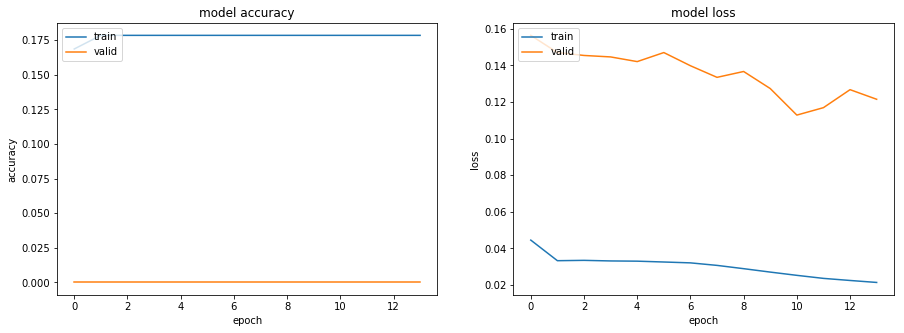

In [222]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [223]:
print("== Reload to best weights saved...")
model.load_weights(model_fn)

== Reload to best weights saved...


In [224]:
batch_size=200 #200
prediction=model.predict([padded_x_query_train,padded_x_doc_train,exact_match_inp_train],
#prediction=model.predict([x_query_train,x_doc_train,exact_match_inp_train],                         
          batch_size=batch_size,
         )

In [225]:
prediction.shape

(14735, 1)

In [226]:
prediction[0]
#y_train[0]

array([ 0.24381661], dtype=float32)

In [227]:
def pred2relevance_categorical(prediction):
#     orig_labels = [ 1.  ,  1.25 , 1.33 , 1.5 ,  1.67,  1.75,  2. ,   2.25 , 2.33  ,2.5 ,  2.67  ,2.75 ,3.  ]
#     new_labels= [ 0 , 1 , 2 , 3 , 4 , 5,  6 , 7 , 8,  9, 10 ,11, 12]
    #resampled
    orig_labels = [ 1.  ,   1.33 ,  1.67,    2. ,  2.33  ,  2.67  ,3.  ]
    new_labels= [ 0 , 1 , 2 , 3 , 4 , 5,  6 ]
    orig_labels_prediction=[]
    for preds in prediction:
        #print(preds)
        max_idx=np.argmax(preds)
        orig_labels_prediction+=[orig_labels[max_idx]]
    return np.array(orig_labels_prediction)

In [228]:
### categorical
orig_labels_prediction =  pred2relevance_categorical(prediction)
print(orig_labels_prediction[0])
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(train_query_df['relevance'].as_matrix(), orig_labels_prediction)**0.5
print(RMSE)

1.0
1.20211717993


In [229]:
### regression
RMSE = mean_squared_error(train_query_df['relevance'].as_matrix(), (prediction*3)+1)**0.5
print(RMSE)

0.61077584489


# print("Predict")
word_a = 'wood'#raw_input('First word: ')
if word_a not in word2idx:
    print('"%s" is not in the index' % word_a)
word_b = 'fan'#raw_input('Second word: ')
if word_b not in word2idx:
    print('"%s" is not in the index' % word_b)
output = model.predict([np.asarray([word2idx[word_a]]), np.asarray([word2idx[word_b]])])
print('%f' % output)

In [230]:
test_df=test_private_df

In [231]:
test_query_sentences = []

print("Parsing sentences from search string")
for query in test_df["search_term"]:
    words,vocab = doc_to_wordlist(query, vocab, remove_stopwords=True)
    test_query_sentences += [words]
    

Parsing sentences from search string


In [232]:
len(test_query_sentences)

78419

In [233]:
test_query_word2vec_idx_list = query_sent2idx(test_query_sentences)

78419


In [234]:
test_joined_df=test_df.join(product_df.set_index('product_uid'), on='product_uid')

test_joined_doc_sentences=[]
for doc in test_joined_df['content']:
    words,vocab = doc_to_wordlist(doc, vocab, remove_stopwords=True)
    test_joined_doc_sentences += [words]
    
test_doc_word2vec_idx_list = query_sent2idx(test_joined_doc_sentences)

78419


In [235]:
x_query_test=np.array(test_query_word2vec_idx_list)[0:78419]
x_doc_test=np.array(test_doc_word2vec_idx_list)[0:78419]

# TODO: replace this with embedding with mask zero rather than padding, need to change index for encoding too, imput dim too.
print("Pad sequences (samples x time)")
x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len,padding='post', truncating='post', value=0.)
x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len,padding='post', truncating='post', value=0.)
# x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len)
# x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len)

# Padding for wide convolution
# Pad input with m-1 zeros from left and right. m is filter size
padded_x_query_test = sequence.pad_sequences(x_query_test, maxlen=query_max_len+(query_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_query_test = sequence.pad_sequences(padded_x_query_test, maxlen=query_max_len+(query_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)
padded_x_doc_test = sequence.pad_sequences(x_doc_test, maxlen=doc_max_len+(doc_filter_size_m-1),\
                                      padding='post', truncating='post', value=0.)
padded_x_doc_test = sequence.pad_sequences(padded_x_doc_test, maxlen=doc_max_len+(doc_filter_size_m-1)*2,\
                                      padding='pre', truncating='pre', value=0.)

print('x_query_test shape:', x_query_test.shape)
print('x_doc_test shape:', x_doc_test.shape)
print('padded_x_query_test shape:', padded_x_query_test.shape)
print('padded_x_doc_test shape:', padded_x_doc_test.shape)

#TODO: y label on 0-1 scale from 1-3
#y_train=(train_query_df['relevance'].as_matrix()-1)/3

# TODO: as categorical
#y_test=to_categorical(train_query_df['relevance_int'].as_matrix(),13)

# y_test=test_query_df['relevance_int'].as_matrix()
#print('y_train shape:', y_train.shape)


Pad sequences (samples x time)
x_query_test shape: (78419, 6)
x_doc_test shape: (78419, 200)
padded_x_query_test shape: (78419, 8)
padded_x_doc_test shape: (78419, 202)


In [236]:
exact_match_list_test=[]
for i in range(x_query_test.shape[0]):
    #print(i)
    c1=x_query_test[i]
    c2=x_doc_test[i]
    #print(c1.shape[0])
    #print(c2.shape[0])

    c1_inp=np.repeat(c1,c2.shape[0],axis=0)
    c1_inp=c1_inp.reshape((c1.shape[0],c2.shape[0]))
    #print(c1_inp.shape)
    #print(c1_inp)

    #print(c2)
    c2_inp=np.tile(c2,(c1.shape[0],1))
    #print(c2_inp.shape)
    #print(c2_inp)    
    #print(c1_inp == c2_inp)
    exact_match_list_test+=[(c1_inp == c2_inp).astype(int)]

exact_match_inp_test=np.array(exact_match_list_test)
exact_match_inp_test.shape

(78419, 6, 200)

In [237]:
print(test_query_df['search_term'][0])
print(x_query_test[0])
print(x_doc_test[0])
print(exact_match_inp_test[0])

90 degree bracket
[1556 6538  858    0    0    0]
[ 1556   385  1033   167   249   467  2193  4375   970  3319  2366  5434
  1123   831   720  1556   385  1033  1963   169   124  2193   785   309
  3977   119    10    80  1238   394  1107   374  2792  4460 21890  1421
   286     2   394   290  6617     3  8202   364   441   839  5434   217
   226   203    58  2684   233   355   850   509   620   785   571   666
     4   872   394  3319  2809  3719   350  1095  7064  1003  6620   970
  9320   831   385   223    24    29    24    29    17    17    15  2339
   167   249     7  1186   217   203   226  1677  6358   615   512   491
    29    17    17    15   385   471  3619   165     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
 

In [238]:
batch_size=200 #200
test_prediction=model.predict([padded_x_query_test,padded_x_doc_test,exact_match_inp_test],
#test_prediction=model.predict([x_query_test,x_doc_test,exact_match_inp_test],
          batch_size=batch_size,
         )

In [239]:
test_prediction.shape

(78419, 1)

In [240]:
test_prediction[0]

array([ 0.14717737], dtype=float32)

In [241]:
### categorical
test_orig_labels_prediction =  pred2relevance_categorical(test_prediction)
print(test_orig_labels_prediction[0])
test_RMSE = mean_squared_error(test_df['relevance'].as_matrix(), test_orig_labels_prediction)**0.5
print(test_RMSE)

1.0
1.48151343796


In [242]:
### regression
test_RMSE = mean_squared_error(test_df['relevance'].as_matrix(), (test_prediction*3)+1)**0.5
print(test_RMSE)

0.74180968571


In [243]:
test_df['relevance'].as_matrix()

array([ 2.33,  2.67,  2.67, ...,  1.  ,  2.67,  2.33])

In [244]:
(test_prediction*3)+1

array([[ 1.44153214],
       [ 1.6975044 ],
       [ 1.99755764],
       ..., 
       [ 1.71504509],
       [ 1.99186182],
       [ 1.824067  ]], dtype=float32)

In [245]:
train_query_df['relevance'].value_counts()

1.33    2105
1.67    2105
2.33    2105
2.67    2105
3.00    2105
2.00    2105
1.00    2105
Name: relevance, dtype: int64

In [246]:
orig_labels_prediction[100:110]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [247]:
test_orig_labels_prediction[100:110]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [248]:
test_df['relevance'].as_matrix()[100:110]

array([ 1.33,  2.33,  2.67,  3.  ,  3.  ,  2.33,  3.  ,  1.67,  3.  ,  3.  ])